In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
import sys
sys.path.append('./src') 
from preprocessor import load_and_preprocess
from tqdm import tqdm
import torch
import qwen
from torch.utils.data import DataLoader, TensorDataset

In [2]:
with h5py.File("lotka_volterra_data.h5", "r") as f:
    # Access the full dataset
    trajectories = f["trajectories"][:] # Shape: (n_systems, n_time_points, n_species)
    time_points = f["time"][:]
    # Access a single trajectory
    system_id = 0 # First system
    # All 100 time points:
    prey_0 = trajectories[0, :, 0]
    predator_0 = trajectories[0, :, 1]
    times = time_points[:]

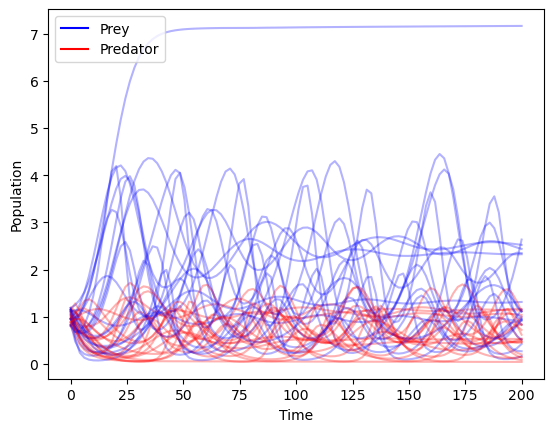

In [3]:
for sys in range(20):
    prey = trajectories[sys, :, 0]
    predator = trajectories[sys, :, 1]
    plt.plot(times, prey, alpha=0.3, c='b')
    plt.plot(times, predator , alpha=0.3, c='r')

plt.xlabel("Time")
plt.ylabel("Population")

plt.plot([], [], label="Prey", c='b')  # Dummy plot for "Prey"
plt.plot([], [], label="Predator", c='r')  # Dummy plot for "Predator"

plt.legend()

# Preprocessing

In [4]:
model, tokenizer = qwen.load_qwen()

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [5]:
train_data , val_data ,norm_factor= load_and_preprocess('lotka_volterra_data.h5')
print(np.shape(train_data))  # First 800 systems
print(np.shape(val_data)) # Last 200 systems
print('Normalisation factor', norm_factor)

(800,)
(200,)
Normalisation factor 3.4500234


In [6]:

tokenised_train = [
    tokenizer(train_data[sys], return_tensors="pt")["input_ids"].tolist()[0] for sys in range(np.shape(train_data)[0]) ]

tokenised_val = [
    tokenizer(val_data[sys], return_tensors="pt")["input_ids"].tolist()[0] for sys in range(np.shape(val_data)[0]) ]


In [7]:
for sys_id in range(2):  # Loop through the first two systems (0 and 1)
    print(f"--- System {sys_id} ---")
    print(f"Preprocessed: {train_data[sys_id]}")
    print(f"Tokenised: {tokenised_train[sys_id]}")
    print('----------------------------------')


--- System 0 ---
Preprocessed: 0.275,0.302;0.215,0.226;0.198,0.164;0.208,0.118;0.239,0.087;0.291,0.067;0.366,0.054;0.465,0.047;0.589,0.045;0.731,0.047;0.881,0.054;1.020,0.069;1.120,0.093;1.153,0.131;1.094,0.183;0.944,0.240;0.739,0.284;0.546,0.294;0.408,0.269;0.331,0.225;0.299,0.179;0.298,0.141;0.321,0.113;0.366,0.092;0.430,0.079;0.513,0.072;0.611,0.071;0.718,0.074;0.822,0.084;0.905,0.101;0.951,0.126;0.943,0.159;0.875,0.196;0.761,0.228;0.630,0.246;0.514,0.242;0.432,0.220;0.386,0.191;0.370,0.161;0.378,0.135;0.406,0.116;0.452,0.102;0.513,0.094;0.585,0.091;0.663,0.093;0.738,0.100;0.798,0.113;0.833,0.131;0.833,0.155;0.794,0.180;0.723,0.202;0.637,0.215;0.555,0.215;0.489,0.204;0.447,0.185;0.428,0.164;0.429,0.144;0.448,0.128;0.483,0.116;0.529,0.109;0.583,0.106;0.641,0.107;0.695,0.113;0.738,0.124;0.761,0.138;0.761,0.155;0.734,0.172;0.686,0.187;0.628,0.196;0.569,0.197;0.520,0.190;0.486,0.177;0.469,0.162;0.469,0.148;0.483,0.135;0.509,0.125;0.545,0.119;0.587,0.117;0.630,0.118;0.670,0.123;0.700,0.1

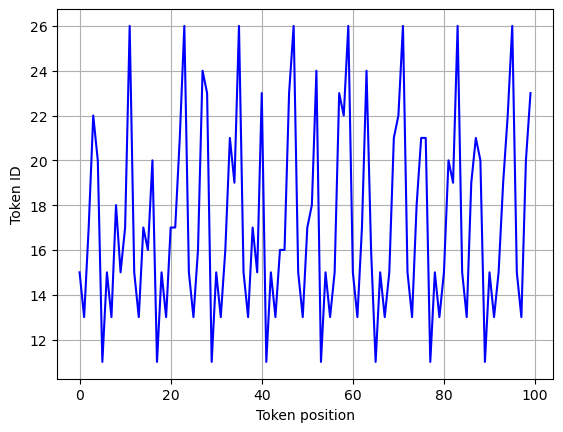

In [8]:
plt.plot(tokenised_train[0][:100], label="Prey", c='b')
plt.xlabel("Token position")
plt.ylabel("Token ID")
plt.grid()

# Untrained model

In [38]:
torch.mps.empty_cache() 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: mps


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [39]:
tokenised_tensors_train = torch.stack([torch.tensor(seq, dtype=torch.long).to(device) for seq in tokenised_train])
tokenised_tensors_val = torch.stack([torch.tensor(seq, dtype=torch.long).to(device) for seq in tokenised_val])
print(tokenised_tensors_train.shape)
print(tokenised_tensors_val.shape)


torch.Size([800, 1199])
torch.Size([200, 1199])


In [40]:
training_token_id = 80*12 # 80 time points, 12 tokens per time point
# predicted_tokens = model.generate(tokenised_tensors_train[:2,:training_token_id], max_new_tokens=239)

In [41]:
# print(np.shape(predicted_tokens))

In [42]:
batch_size = 1
num_batches = 3  

# Set the maximum number of tokens to generate
max_new_tokens = 239

# The model is assumed to be on the correct device (e.g., `device`), 
# and tokenized tensors (train) are already prepared.

# Initialize a list to store predicted tokens
predicted_tokens_list = []

# Create a progress bar
for batch_idx in tqdm(range(num_batches), desc="Generating Tokens"):
    # Get the start and end indices for the current batch
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, tokenised_tensors_train.shape[0])

    # Slice the data for the current batch and set the `training_token_id`
    batch_data = tokenised_tensors_train[start_idx:end_idx, :training_token_id]

    # Generate predictions for the batch
    predicted_tokens_batch = model.generate(batch_data, max_new_tokens=max_new_tokens)
    
    # Store the predicted tokens for this batch
    predicted_tokens_list.append(predicted_tokens_batch)

# After looping through the batches, convert the list of predicted tokens to a tensor
all_predicted_tokens = torch.cat(predicted_tokens_list, dim=0)


Generating Tokens: 100%|██████████| 3/3 [01:02<00:00, 20.84s/it]


In [53]:
 
# Set the maximum number of tokens to generate
max_new_tokens = 239

# Initialize a list to store predicted tokens
predicted_tokens_list = []
num_sys = 6

model.eval()
# Create a progress bar
for sys in tqdm(range(num_sys), desc="Generating Tokens"):
    # Slice the data for the current batch and set the `training_token_id`
    data = tokenised_tensors_train[sys][ :training_token_id]
    data = data.unsqueeze(0)
    print('before to device')
    data = data.to(device)
    print('after to device')
    # Generate predictions for the batch
    print('before generate')
    predicted_tokens_batch = model.generate(data, max_new_tokens=max_new_tokens)
    print('after generate')
    # Store the predicted tokens for this batch
    predicted_tokens_list.append(predicted_tokens_batch)

# After looping through the batches, convert the list of predicted tokens to a tensor
all_predicted_tokens = torch.cat(predicted_tokens_list, dim=0)


Generating Tokens:   0%|          | 0/6 [00:00<?, ?it/s]

before to device
after to device
before generate


Generating Tokens:  17%|█▋        | 1/6 [00:14<01:10, 14.18s/it]

after generate
before to device
after to device
before generate


Generating Tokens:  33%|███▎      | 2/6 [00:27<00:55, 13.86s/it]

after generate
before to device
after to device
before generate


Generating Tokens:  50%|█████     | 3/6 [00:41<00:41, 13.84s/it]

after generate
before to device
after to device
before generate


Generating Tokens:  67%|██████▋   | 4/6 [00:55<00:27, 13.73s/it]

after generate
before to device
after to device
before generate


Generating Tokens:  83%|████████▎ | 5/6 [01:08<00:13, 13.68s/it]

after generate
before to device
after to device
before generate


Generating Tokens: 100%|██████████| 6/6 [01:22<00:00, 13.74s/it]

after generate


In [44]:
# batch_size = 2
# max_new_tokens = 239

# # Calculate the number of batches
# n_batches = (len(tokenised_tensors_train) + batch_size - 1) // batch_size  # ceil division

# # Initialize an empty list to store the predicted tokens
# all_predicted_tokens = []

# n_batches=3

# # Loop over batches
# for i in tqdm(range(n_batches), desc="Generating tokens", unit="batch"):
#     # Get the batch (slicing tokenized tensors)
#     start_idx = i * batch_size
#     end_idx = min(start_idx + batch_size, len(tokenised_tensors_train))
#     batch = tokenised_tensors_train[start_idx:end_idx]

#     # Ensure batch is in the correct shape (batch_size, sequence_length)
#     # If using a tensor, you can do this directly
#     # If using a list, convert to tensor:
#     if isinstance(batch, list):
#         batch = torch.stack(batch)

#     # Generate tokens for this batch
#     predicted_tokens_batch = model.generate(batch, max_new_tokens=max_new_tokens)
#     # Store the generated tokens
#     all_predicted_tokens.append(predicted_tokens_batch)

# # Optionally, concatenate all predicted tokens into a single tensor/list
# all_predicted_tokens = torch.cat(all_predicted_tokens, dim=0)

In [54]:
print('Traget tokens:', tokenised_tensors_train[0, training_token_id:training_token_id + 40])
print('Predicted tokens:', all_predicted_tokens[0, :40])

Traget tokens: tensor([15, 13, 22, 15, 15, 11, 15, 13, 16, 18, 16, 26, 15, 13, 22, 16, 21, 11,
        15, 13, 16, 19, 17, 26, 15, 13, 22, 16, 18, 11, 15, 13, 16, 20, 20, 26,
        15, 13, 21, 24], device='mps:0')
Predicted tokens: tensor([15, 13, 17, 22, 20, 11, 15, 13, 18, 15, 17, 26, 15, 13, 17, 16, 20, 11,
        15, 13, 17, 17, 21, 26, 15, 13, 16, 24, 23, 11, 15, 13, 16, 21, 19, 26,
        15, 13, 17, 15], device='mps:0')


In [55]:
decoded_predictions = [
    tokenizer.decode(tokens, skip_special_tokens=True) for tokens in all_predicted_tokens
]

print('Predictions:', decoded_predictions[0][training_token_id:training_token_id + 60])
print('Target:', train_data[0][training_token_id:training_token_id + 60])


Predictions: 0.705,0.130;0.738,0.136;0.761,0.143;0.761,0.157;0.734,0.165;
Target: 0.700,0.131;0.716,0.142;0.713,0.155;0.693,0.168;0.659,0.178;


In [56]:
# print('Target tokens: ', tokenised_tensors_val[0][:40])
# print('Predicted tokens: ', all_predicted_tokens[0,960:1000])

In [57]:
# decoded_predictions = [
#     tokenizer.decode(all_predicted_tokens[sys], skip_special_tokens=True) for sys in range(np.shape(all_predicted_tokens)[0])]

# print('Predictions:',decoded_predictions[0][960:1098])
# print('Validation: ',val_data[0][:138])

In [58]:
def reverse_preprocessing(data):
    # Split the string by semicolons to get pairs
    pairs = data.split(';')
    
    # Remove any empty string after the final semicolon
    pairs = [pair for pair in pairs if pair]
    
    # Initialize two empty arrays for A and B
    A = []
    B = []
    
    # Iterate over each pair, split it by comma, and append to respective arrays
    for pair in pairs:
        a, b = pair.split(',')
        A.append(float(a))  # Convert the first part to float and append to A
        B.append(float(b))  # Convert the second part to float and append to B
    
    return A, B

In [59]:
predicted_prey = []
predicted_predator = []

for sys in range(len(decoded_predictions)):
    prey , pred = reverse_preprocessing(decoded_predictions[sys])
    predicted_prey.append(prey)
    predicted_predator.append(pred)



In [60]:
def mse(pred, true):
    return np.mean((np.array(pred) - np.array(true))**2)


System 1: Prey MSE = 0.00, Predator MSE = 0.01
System 2: Prey MSE = 0.02, Predator MSE = 0.00
System 3: Prey MSE = 0.00, Predator MSE = 0.00
System 4: Prey MSE = 0.03, Predator MSE = 0.01
System 5: Prey MSE = 0.00, Predator MSE = 0.00
System 6: Prey MSE = 0.02, Predator MSE = 0.01


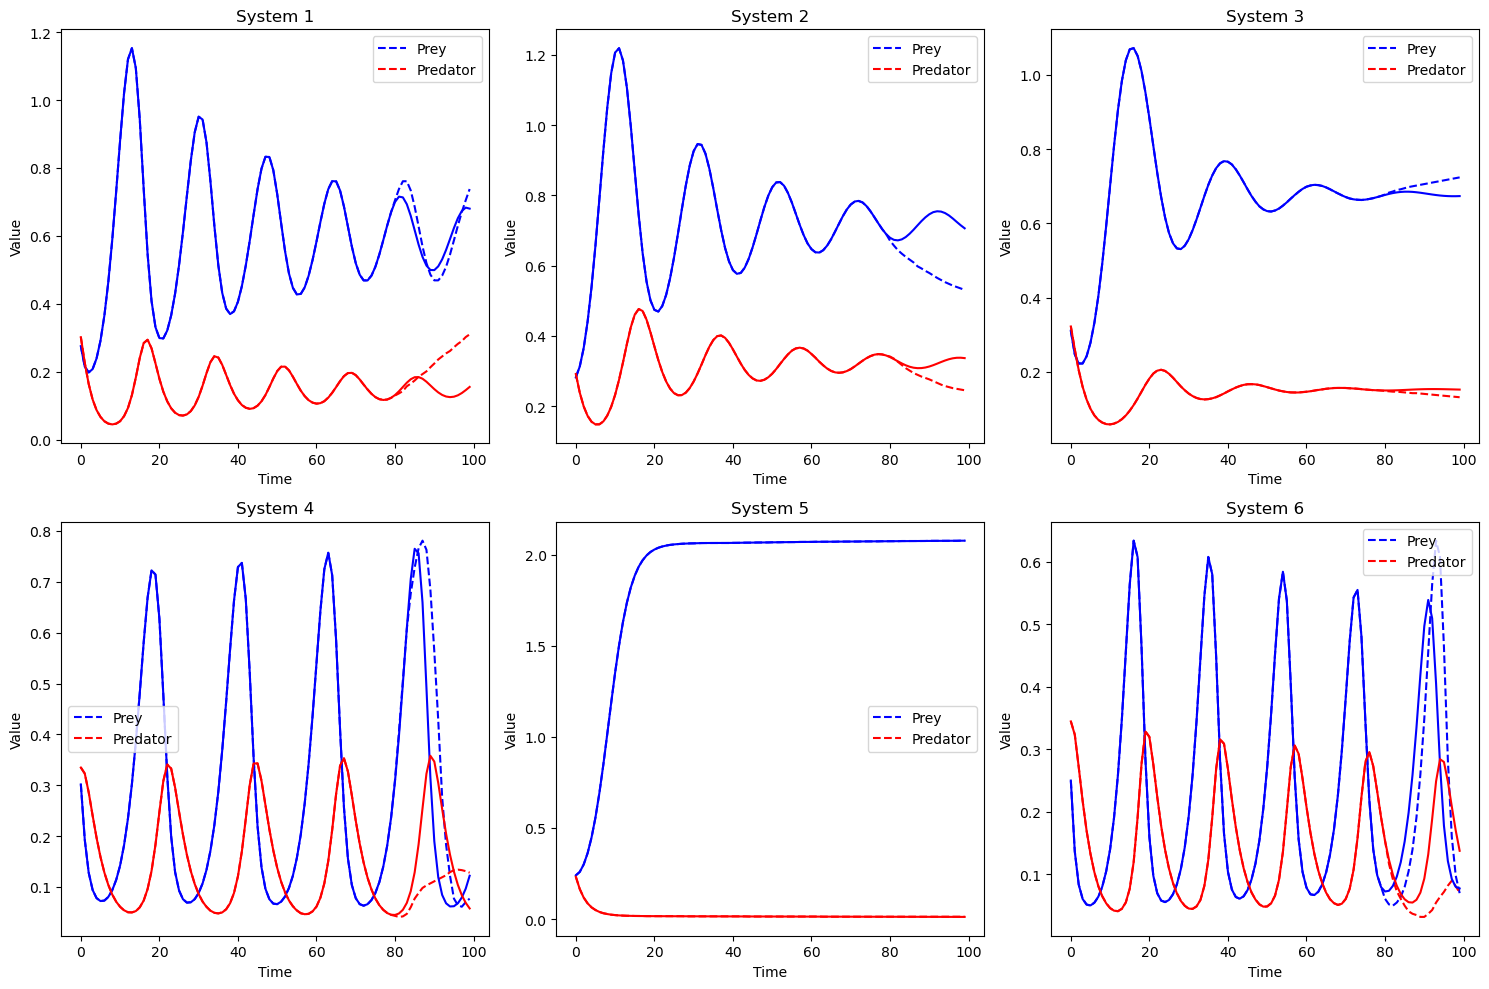

In [61]:

# Number of systems you want to plot (e.g., 6 systems)
num_systems = 6
num_rows = 2
num_columns = 3

# Create a figure with a grid of num_rows and num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))

# Flatten axes array if it's 2D
axes = axes.flatten()

# Loop through each system and plot on the corresponding subplot
for sys in range(num_systems):
    axes[sys].plot(predicted_prey[sys], label="Prey", c='b',linestyle='--')
    axes[sys].plot(predicted_predator[sys], label="Predator", c='r',linestyle='--')
    axes[sys].plot(trajectories[sys][:,0]/norm_factor, c='b') 
    axes[sys].plot(trajectories[sys][:,1]/norm_factor, c='r')

    # Add labels and title for each subplot
    axes[sys].set_title(f'System {sys+1}')
    axes[sys].set_xlabel('Time')
    axes[sys].set_ylabel('Value')

    # Add a legend
    axes[sys].legend()

    mse_prey = mse(predicted_prey[sys][80:], trajectories[sys][80:,0]/norm_factor)
    mse_predator = mse(predicted_predator[sys][80:], trajectories[sys][80:,1]/norm_factor)
    print(f"System {sys+1}: Prey MSE = {mse_prey:.2f}, Predator MSE = {mse_predator:.2f}") 
    

plt.tight_layout()

# Show the plot
plt.show()


In [62]:
torch.mps.empty_cache() 
model = AutoModelForCausalLM.from_pretrained(model_name)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")
model.to(device)

NameError: name 'model_name' is not defined

In [9]:
tokenised_tensors = torch.stack([torch.tensor(seq, dtype=torch.long).to(device) for seq in tokenised_trajectories])
print(tokenised_tensors.shape)

torch.Size([1000, 1199])


In [10]:
n_input_points = 80
n_input_tokens = 12 * n_input_points

n_future_points = 100 - n_input_points
n_future_tokens = 12 * n_future_points 

input_tokens = tokenised_tensors[:, :n_input_tokens]
future_tokens = tokenised_tensors[:, n_input_tokens:n_input_tokens+n_future_tokens]

print(input_tokens.shape)
print(future_tokens.shape)
print(n_input_tokens)
print(n_future_tokens)


torch.Size([1000, 960])
torch.Size([1000, 239])
960
240


In [11]:
batch_size = 5  # Adjust as needed

# Create dataset & DataLoader
dataset = TensorDataset(input_tokens, future_tokens)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model.eval() 
all_predicted_tokens = []

with torch.no_grad():  # Disable gradients for faster inference
    for batch in tqdm(dataloader, desc="Processing Batches", unit="batch"):
        input_batch, target_batch = batch  # Unpack batch
        input_batch = input_batch.to(device)  # Move to GPU

        # Forward pass: Generate predictions
        outputs = model(input_batch)  # Assuming model returns logits
        logits = outputs.logits  # Shape: (batch_size, seq_length, vocab_size)

        # Convert logits to token predictions
        predicted_tokens = torch.argmax(logits, dim=-1)  # Shape: (batch_size, seq_length)
        predicted_tokens = predicted_tokens[:, :n_future_tokens-1]  # Trim to future tokens only
        # Store results
        all_predicted_tokens.append(predicted_tokens.cpu())  # Move to CPU if needed

# Combine all predictions
all_predicted_tokens = torch.cat(all_predicted_tokens, dim=0)  # Shape: (total_samples, n_output_tokens)

# Evaluate Performance
target_tokens = future_tokens.cpu()  # Ensure on CPU for comparison

Processing Batches:   0%|          | 0/200 [00:00<?, ?batch/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Processing Batches: 100%|██████████| 200/200 [11:45<00:00,  3.53s/batch]


In [12]:
# Compute accuracy (example metric)
print(n_future_tokens)
print(all_predicted_tokens.shape)
print(target_tokens.shape)
accuracy = (all_predicted_tokens == target_tokens).float().mean().item()
print(f"Model Accuracy: {accuracy:.4f}")

240
torch.Size([1000, 239])
torch.Size([1000, 239])
Model Accuracy: 0.0384


In [13]:
target_texts = [tokenizer.decode(token_ids, skip_special_tokens=False) for token_ids in np.array(target_tokens)]
predicted_texts = [tokenizer.decode(token_ids, skip_special_tokens=False) for token_ids in np.array(all_predicted_tokens)]

print('Target points: ',target_texts[0], 'Predicted point: ',predicted_texts[0])
print('Target points: ',target_texts[1], 'Predicted point: ',predicted_texts[1])
print('Target points: ',target_texts[2], 'Predicted point: ',predicted_texts[2])

# The predicted tokens aren't in the same format as the target tokens - run this on 10 and get MSE after removing weird bits

Target points:  0.700,0.131;0.716,0.142;0.713,0.155;0.693,0.168;0.659,0.178;0.617,0.184;0.574,0.184;0.538,0.179;0.513,0.170;0.500,0.160;0.499,0.149;0.510,0.139;0.531,0.132;0.559,0.127;0.591,0.125;0.623,0.126;0.652,0.130;0.673,0.137;0.683,0.146;0.680,0.155 Predicted point:  0055 \ .225, .275,0.385;0.198,0.298;0.105,0.188;0.115,0.085;0.258,0.065;0.305,0.051;0.408,0.042;0.565,0.041;0.705,0.043;0.855,0.044;0.005,0.067;1.180,0.070;1.290,0.110;1.120,0.160;0.958,0.245;0.891,0.399;0.518,0.399;0.308,0.398;0.203,0.245;
Target points:  0.679,0.339;0.673,0.334;0.672,0.327;0.675,0.321;0.681,0.316;0.691,0.312;0.702,0.309;0.715,0.308;0.727,0.308;0.737,0.310;0.746,0.313;0.752,0.316;0.755,0.321;0.754,0.325;0.750,0.330;0.743,0.333;0.734,0.336;0.724,0.338;0.715,0.338;0.706,0.337 Predicted point:  00558 .285, .202,0.394;0.325,0.295;0.407,0.148;0.503,0.141;0.625,0.130;0.771,0.141;0.903,0.145;1.001,0.162;1.184,0.199;1.250,0.210;1.289,0.265;1.298,0.311;1.146,0.365;1.980,0.421;0.884,0.471;0.734,0.499;0.612,0.

In [54]:
def reverse_processing(processed_trajectories):
    trajectories = []
    for sys in processed_trajectories:
        trajectory = []
        time_steps = sys.split(';')
        # print(time_steps)
        for step in time_steps:
            try:
                prey_val, predator_val = step.split(',')
                prey_val = float(prey_val)
                predator_val = float(predator_val)
            except ValueError:
                prey_val = np.nan
                predator_val = np.nan
            if len(trajectory) < n_future_points - 1:
                trajectory.append([prey_val, predator_val])
        trajectories.append(np.array(trajectory))
    return np.array(trajectories)

In [60]:
final_predicted_trajectories = reverse_processing(predicted_texts)
final_target_trajectories = reverse_processing(target_texts)
squared_error = (final_predicted_trajectories - final_target_trajectories) ** 2
mask = np.isnan(final_predicted_trajectories)

# Set squared error to NaN wherever final_predicted_trajectories is NaN
squared_error[mask] = np.nan

# Compute the Mean Squared Error while ignoring NaNs
mse = np.nanmean(squared_error)

print(f"Mean Squared Error (ignoring NaNs in predicted trajectories): {mse:.4f}")

Mean Squared Error (ignoring NaNs in predicted trajectories): 0.1164


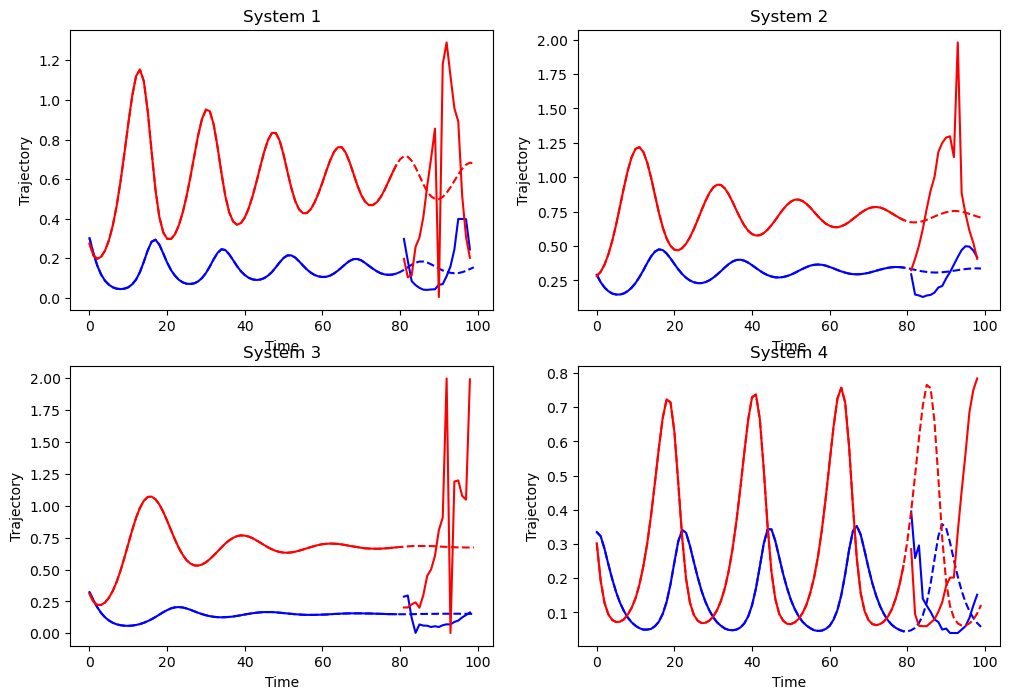

In [114]:
total_pred_trajectories = np.stack(trajectories[:, n_input_points:, :], axis=0)
combined_trajectories = np.concatenate((scaled_trajectories[:, :n_input_points, :], final_predicted_trajectories), axis=1)

n_systems = 4
ncols = 2  # For example, 2 columns
nrows = (n_systems + ncols - 1) // ncols  # Calculate number of rows based on n_systems and ncols

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 4))

# Flatten axes array for easier iteration if nrows > 1
axes = axes.flatten()

for sys in range(n_systems):
    ax = axes[sys]  # Get the axis for the current system (subplot)
    
    # Plot the pred and prey trajectories for the current system
    ax.plot(combined_trajectories[sys, :, 1], label="Pred", c='b')
    ax.plot(scaled_trajectories[sys, :, 1], label="Prey", c='b', linestyle='--')

    ax.plot(combined_trajectories[sys, :, 0], label="Prey", c='r')
    ax.plot(scaled_trajectories[sys, :, 0], label="Prey", c='r', linestyle='--')

    # Set labels and title
    ax.set_title(f"System {sys+1}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Trajectory')


In [ ]:
generated_predictions = model

In [14]:
# # Perform inference without gradients (faster)
# with torch.no_grad():
#     outputs = model(tokenized_tensors)

# # Extract the next token predictions (logits)
# logits = outputs.logits  # Shape: (batch_size, seq_length, vocab_size)
# predicted_tokens = torch.argmax(logits, dim=-1)  # Get most likely token IDs

# from tqdm import tqdm
# import torch

# # Perform inference with progress bar
# with torch.no_grad():
#     # Initialize the tqdm progress bar
#     for batch in tqdm(tokenized_tensors, desc="Processing", unit="batch"):
#         # Perform inference for each batch
#         outputs = model(batch)
        
#         # Extract the next token predictions (logits)
#         logits = outputs.logits  # Shape: (batch_size, seq_length, vocab_size)
#         predicted_tokens = torch.argmax(logits, dim=-1)  # Get most likely token IDs


In [15]:
# from torch.nn.utils.rnn import pad_sequence
# import os
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

# # Example batch size
# batch_size = 64

# # Ensure sequences are padded to the same length
# tokenized_tensors_padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in tokenised_trajectories], batch_first=True)

# # Perform inference with progress bar
# with torch.no_grad():
#     # Create a progress bar for batches
#     for i in tqdm(range(0, len(tokenized_tensors_padded), batch_size), desc="Processing Batches", unit="batch"):
#         # Slice the data into the current batch
#         batch = tokenized_tensors_padded[i:i + batch_size]
        
#         # Ensure batch is on the correct device
#         batch = batch.to(device)
        
#         # Perform inference for the current batch
#         outputs = model(batch)
        
#         # Extract the next token predictions (logits)
#         logits = outputs.logits  # Shape: (batch_size, seq_length, vocab_size)
#         predicted_tokens = torch.argmax(logits, dim=-1)  # Get most likely token IDs

In [16]:


# # dataset = TensorDataset(tokenised_tensors)

# # dataloader = DataLoader(dataset, batch_size=5, shuffle=False)
# # model.eval()
# # all_predicted_tokens = []

# subset_indices = range(20)  # Select the first 1000 samples, for example

# # Use only the subset of tokenized tensors for the TensorDataset
# subset_tokenised_tensors = tokenised_tensors[subset_indices]

# # Create the dataset with the subset of data
# dataset = TensorDataset(subset_tokenised_tensors)

# # Create the DataLoader for the subset (with batch_size = 5)
# dataloader = DataLoader(dataset, batch_size=5, shuffle=False)
# model.eval()
# all_predicted_tokens = []

# with torch.no_grad(): # Perform inference without gradients
#     for batch in tqdm(dataloader, desc="Processing", unit="batch"):
#         batch = batch[0].to(device) 
        
#         # Forward pass: Get model outputs (logits)
#         outputs = model(batch)
        
#         # Extract the logits (raw predictions before applying softmax)
#         logits = outputs.logits  # Shape: (batch_size, seq_length, vocab_size)
        
#         # Get the most likely token IDs (i.e., the token with the highest probability)
#         predicted_tokens = torch.argmax(logits, dim=-1)  # Shape: (batch_size, seq_length)
        
#         # Store the predicted tokens (append them for later analysis)
#         all_predicted_tokens.append(predicted_tokens.cpu())  # Move to CPU if needed

# # Combine all predictions into a single tensor
# all_predicted_tokens = torch.cat(all_predicted_tokens, dim=0)

# # Optionally, you can convert these back to words/characters using `id_to_token` mapping
# # # For example, if you have `id_to_token`, you can map the token IDs back to the original tokens:
# # predicted_texts = [id_to_token[token.item()] for token in all_predicted_tokens]

# # print(predicted_texts[:10])  # Show the first 10 predicted tokens


In [17]:
predicted_texts = [tokenizer.decode(token_ids, skip_special_tokens=False) for token_ids in np.array(all_predicted_tokens)]
print(all_predicted_tokens[0][:60])  # Show the first 10 predicted tokens
print(predicted_texts[0][:60])  # Show the first 10 predicted tokens


tensor([  15,   15,   20,   20, 1124,  220,   13,   17,   17,   20,   11,  220,
          13,   17,   22,   20,   11,   15,   13,   18,   23,   20,   26,   15,
          13,   16,   24,   23,   11,   15,   13,   17,   24,   23,   26,   15,
          13,   16,   15,   20,   11,   15,   13,   16,   23,   23,   26,   15,
          13,   16,   16,   20,   11,   15,   13,   15,   23,   20,   26,   15])
0055 \ .225, .275,0.385;0.198,0.298;0.105,0.188;0.115,0.085;


In [18]:
def reverse_processing(processed_trajectories):
    trajectories = []
    for sys in processed_trajectories:
        trajectory = []
        time_steps = sys.split(';')
        prey = []
        predator = []
        # print(time_steps)
        for step in time_steps:
            try:
                prey_val, predator_val = step.split(',')
                prey_val = float(prey_val)
                predator_val = float(predator_val)
            except ValueError:
                prey_val = np.nan
                predator_val = np.nan
            trajectory.append([prey_val, predator_val])
        trajectories.append(trajectory)
    return np.array(trajectories)



In [19]:
for sys in range(20):
    prey = reverse_processing(predicted_texts)[sys,:,0]
    predator = reverse_processing(predicted_texts)[sys,:,1]
    plt.plot(times,prey, label="Prey", alpha=0.3, c='b')
    plt.plot(times,predator, label="Predator", alpha=0.3, c='r')

plt.xlabel("Time")
plt.ylabel("Population")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1000,) + inhomogeneous part.